<a href="https://www.kaggle.com/code/neelsubodhmehta/customer-churn?scriptVersionId=126959982" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Import modules

In [37]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import pickle
from sklearn import preprocessing
from sklearn import model_selection
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import roc_auc_score,r2_score,mean_absolute_error,mean_squared_error,accuracy_score,classification_report,confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

## data loading

In [63]:
df = pd.read_csv('/kaggle/input/supplychainfull/DataCoSupplyChainDataOut.csv',header= 0,encoding='unicode_escape')
df = df.drop(columns=['Unnamed: 0'])
df.head()

,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Delivery Status,Late_delivery_risk,Category Id,Category Name,Customer City,...,Shipping Mode,order_date,shipping_date,order_year,order_month,order_day,shipping_year,shipping_month,shipping_day,churn_flag
0,DEBIT,3,4,91.250000,314.640015,Advance shipping,0,73,Sporting Goods,Caguas,...,Standard Class,2018-01-31 22:56:00,2018-02-03 22:56:00,2018,1,31,2018,2,3,0
1,TRANSFER,5,4,-249.089996,311.359985,Late delivery,1,73,Sporting Goods,Caguas,...,Standard Class,2018-01-13 12:27:00,2018-01-18 12:27:00,2018,1,13,2018,1,18,0
2,CASH,4,4,-247.779999,309.720001,Shipping on time,0,73,Sporting Goods,San Jose,...,Standard Class,2018-01-13 12:06:00,2018-01-17 12:06:00,2018,1,13,2018,1,17,0
3,DEBIT,3,4,22.860001,304.809998,Advance shipping,0,73,Sporting Goods,Los Angeles,...,Standard Class,2018-01-13 11:45:00,2018-01-16 11:45:00,2018,1,13,2018,1,16,0
4,PAYMENT,2,4,134.210007,298.250000,Advance shipping,0,73,Sporting Goods,Caguas,...,Standard Class,2018-01-13 11:24:00,2018-01-15 11:24:00,2018,1,13,2018,1,15,0


## EDA

In [64]:
def data_info(data):
    print('1) Number of columns are : ',data.shape[1])
    print('2) Number of rows are : ',data.shape[0])
    print('3) Total number of data-points :',data.size)
    numerical_features = [f for f in data.columns if data[f].dtypes!='O']
    print('4) Count of Numerical Features :',len(numerical_features))
    cat_features = [c for c in data.columns if data[c].dtypes=='O']
    print('5) Count of Categorical Features :',len(cat_features))
data_info(df)

1) Number of columns are :  62
2) Number of rows are :  180519
3) Total number of data-points : 11192178
4) Count of Numerical Features : 36
5) Count of Categorical Features : 26


### Missing values identification

In [65]:
def features_with_missing_values(data):
    x = data.isnull().sum().sum()/(data.shape[0]*data.shape[1])*100
    print('Percentage of Total Missing Values is ' ,round(x,2) ,'%')
    print('Missing Value Estimation :')
    for i in data.columns:
        if data[i].isna().sum()>0:
            print('The Feature ',i,' has '+ str(data[i].isna().sum()) + ' missing values')
            
features_with_missing_values(df)

Percentage of Total Missing Values is  3.0 %
Missing Value Estimation :
The Feature  Customer Lname  has 8 missing values
The Feature  Customer Zipcode  has 3 missing values
The Feature  Order Zipcode  has 155679 missing values
The Feature  Product Description  has 180519 missing values


<AxesSubplot:xlabel='Days for shipment (scheduled)', ylabel='Days for shipping (real)'>

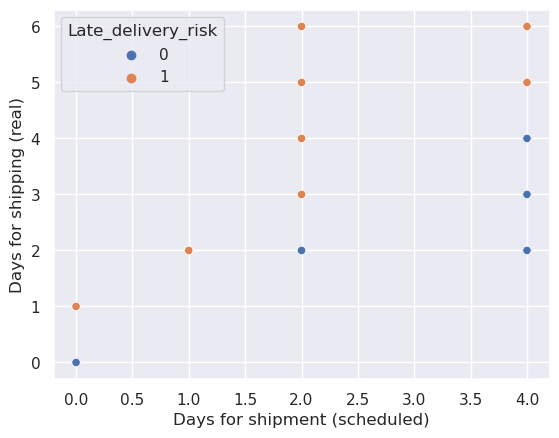

In [66]:
# Target value analysis
sns.set()
sns.scatterplot(x="Days for shipment (scheduled)",y="Days for shipping (real)",hue="Late_delivery_risk",data=df)

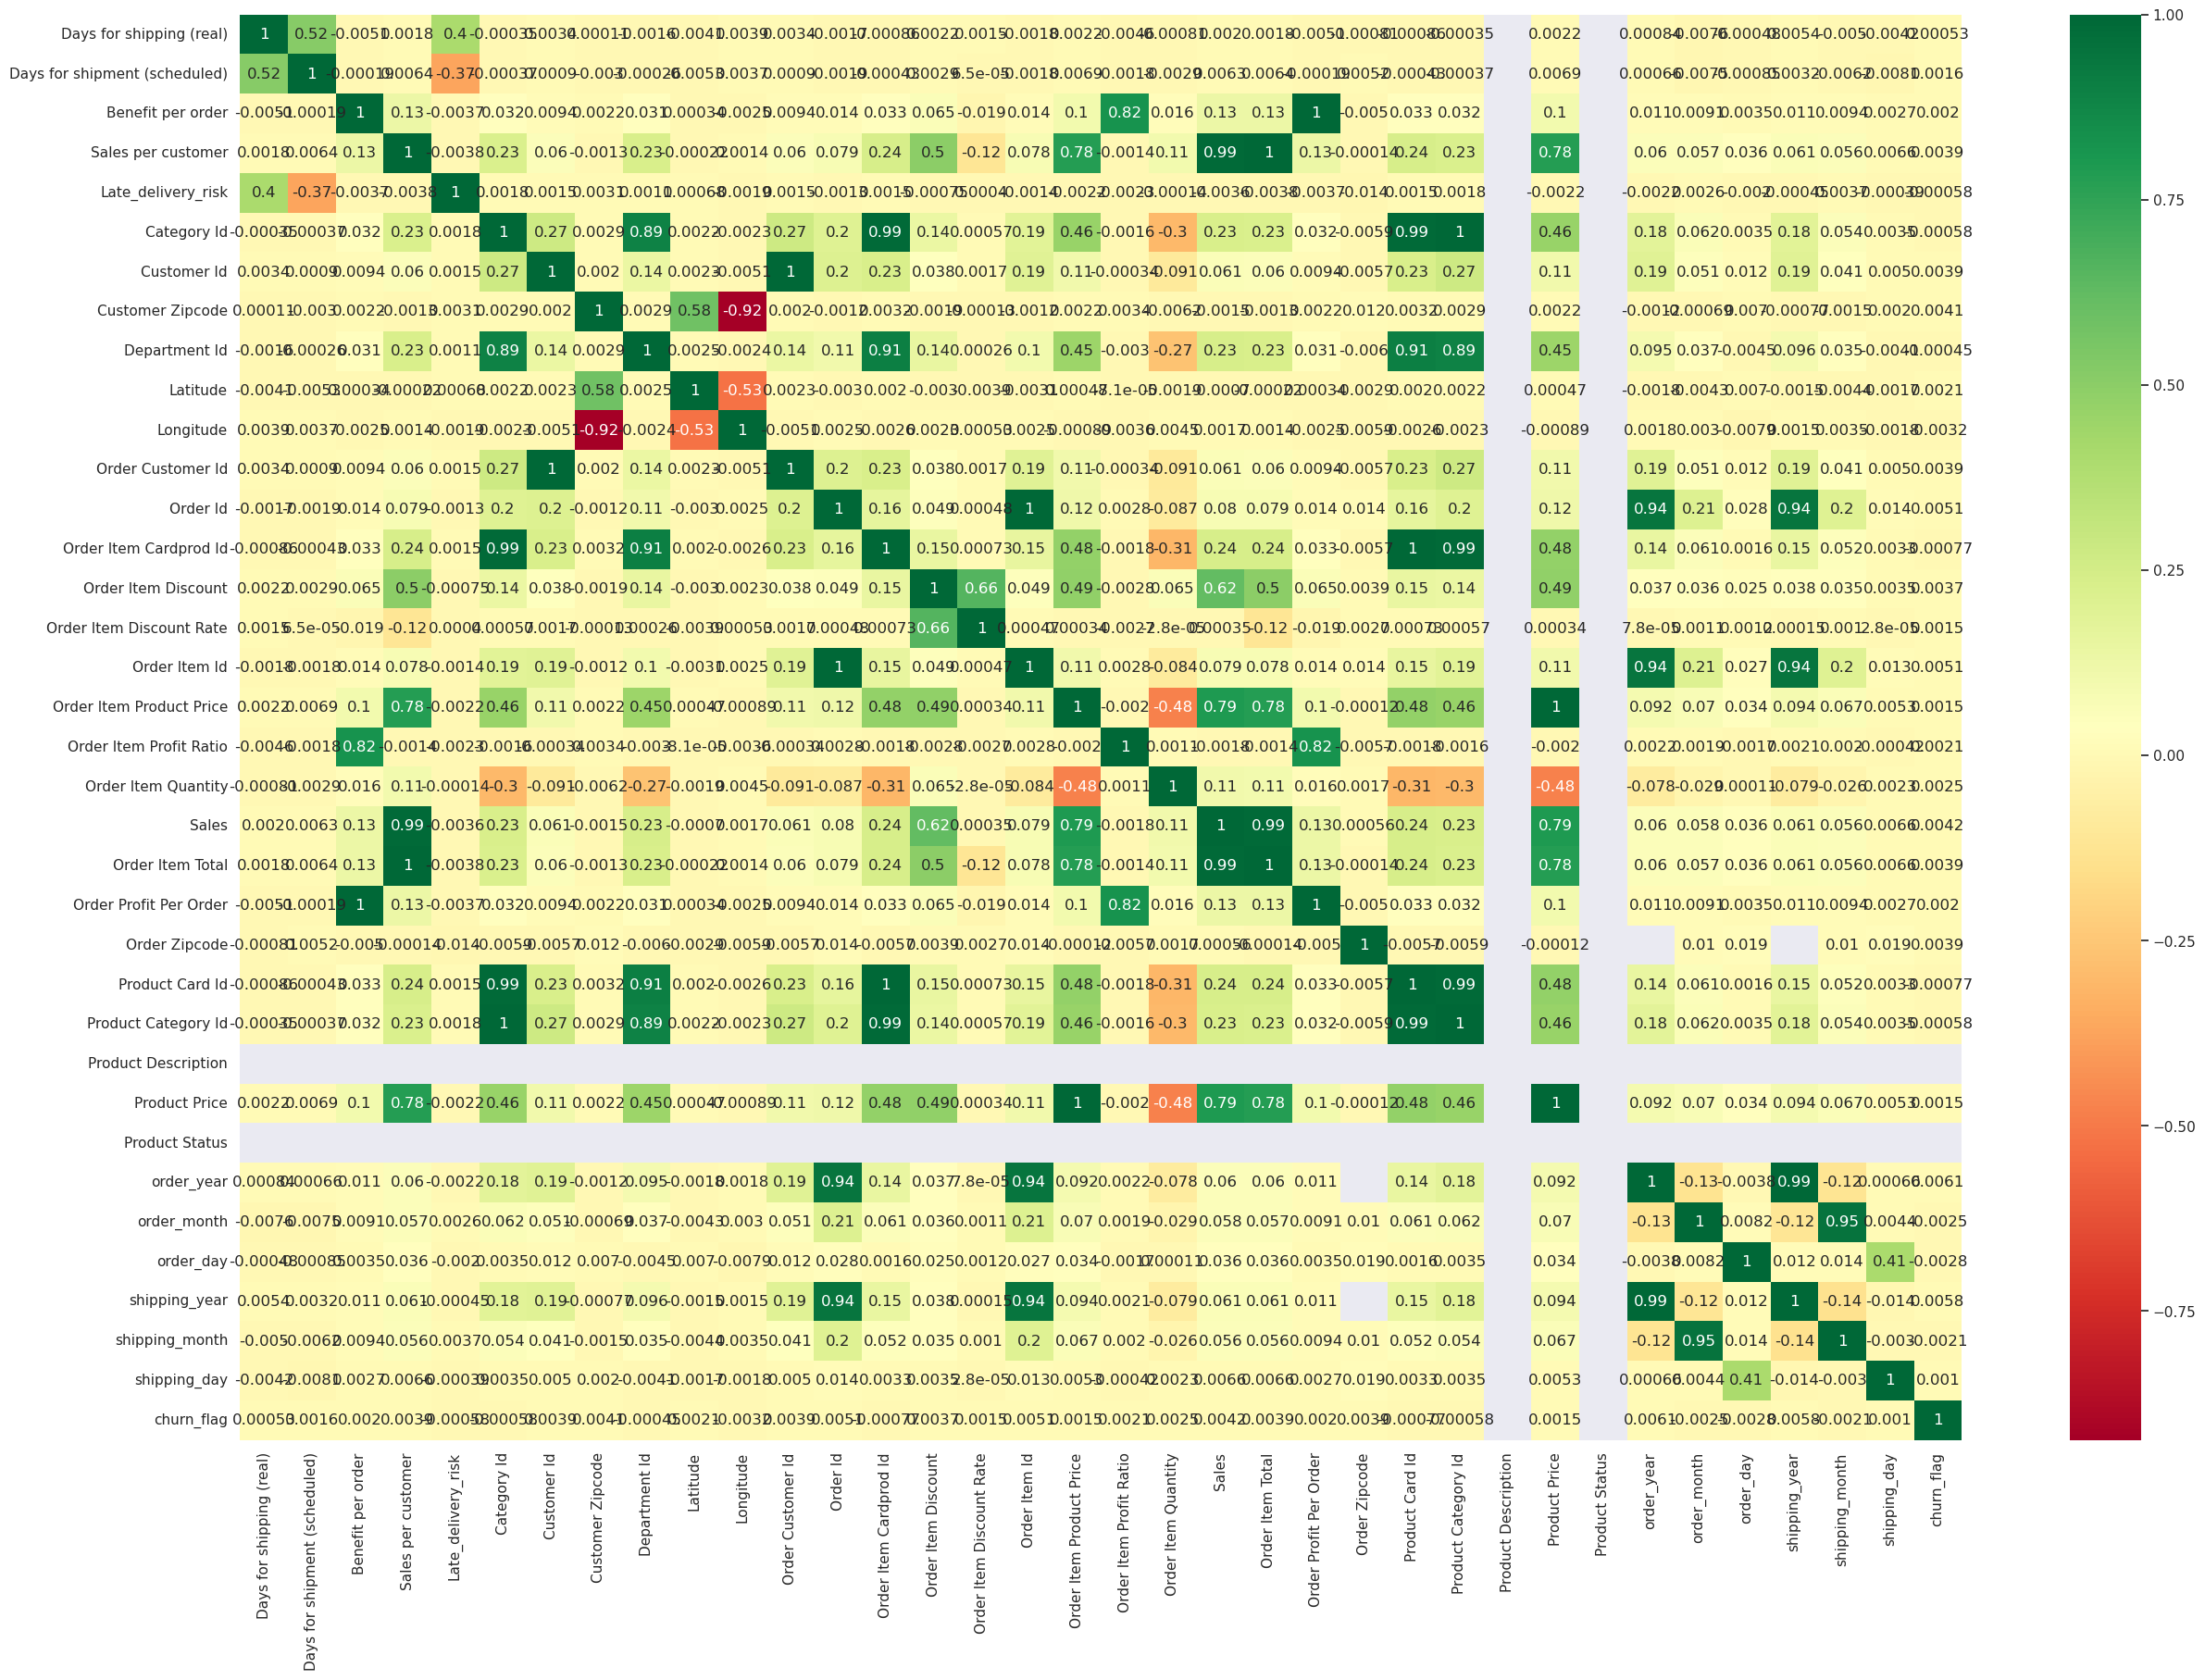

In [67]:
corrmap = df.corr()
top=corrmap.index
plt.figure(figsize=(30,20))
g=sns.heatmap(df[top].corr(),annot=True,cmap="RdYlGn")

## Insights from Heatmap:

1. Columns that are similar with same values but with different metadata (duplicate columns)

- [Benefit per order], Order Profit per order

- [Sales per customer], Sales, Order Item Total

- [Category ID], Product Category ID, Order Customer ID, Order Item Category ID, Product card ID,

- [Order Item Product Price],Product Price

2. Unwanted features(null or less correlated values)

- Product Description
- Product Status

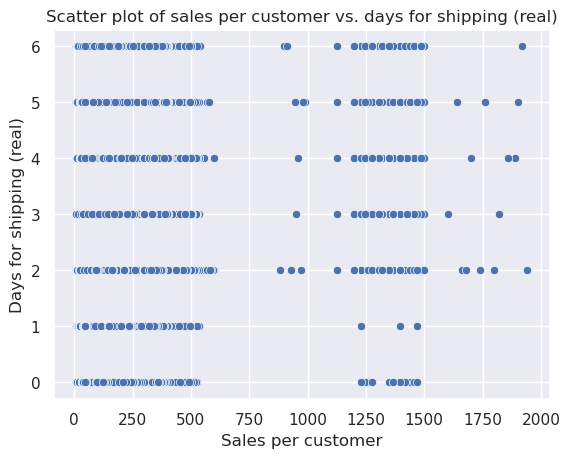

In [68]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(data=df, x='Sales per customer', y='Days for shipping (real)')
plt.xlabel('Sales per customer')
plt.ylabel('Days for shipping (real)')
plt.title('Scatter plot of sales per customer vs. days for shipping (real)')

# Show the plot
plt.show()

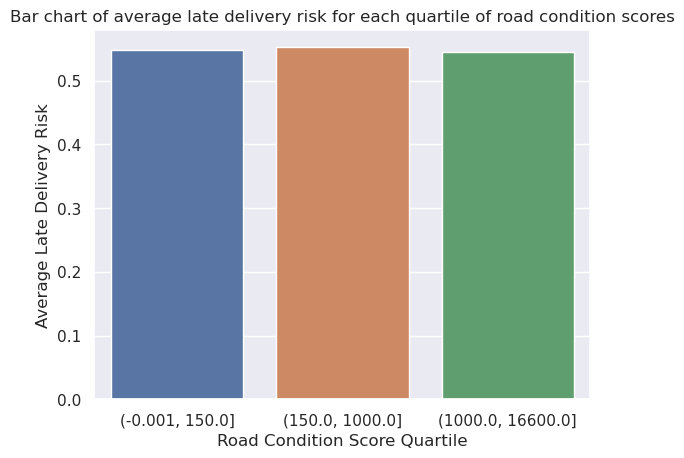

In [69]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

data = df
city_data = pd.read_csv('/kaggle/input/cityroad/city_score_1.csv')

merged_data = pd.merge(data, city_data, on='Customer City')

merged_data['Road Condition Score Quartile'] = pd.qcut(merged_data['Road Condition Score'], q=4, duplicates ="drop")

# Calculate the average late delivery risk for each quartile
quartile_risk = merged_data.groupby('Road Condition Score Quartile')['Late_delivery_risk'].mean()

# Create the bar chart
sns.barplot(x=quartile_risk.index, y=quartile_risk.values)

# Add axis labels and a title
plt.xlabel('Road Condition Score Quartile')
plt.ylabel('Average Late Delivery Risk')
plt.title('Bar chart of average late delivery risk for each quartile of road condition scores')

# Show the plot
plt.show()

In [46]:
city_data.columns

Index(['Customer City', 'Road Condition Score'], dtype='object')

In [47]:
# Splitting features 

shipment_features = ['Type','Days for shipping (real)','Days for shipment (scheduled)','Late_delivery_risk','Benefit per order',
                        'Sales per customer','Latitude','Longitude','Shipping Mode','Order Status','Order Region',
                        'Order Country','Order City','Market','Delivery Status']
shipment = df[shipment_features]
shipment.head()

,Type,Days for shipping (real),Days for shipment (scheduled),Late_delivery_risk,Benefit per order,Sales per customer,Latitude,Longitude,Shipping Mode,Order Status,Order Region,Order Country,Order City,Market,Delivery Status
0,DEBIT,3,4,0,91.250000,314.640015,18.251453,-66.037056,Standard Class,COMPLETE,Southeast Asia,Indonesia,Bekasi,Pacific Asia,Advance shipping
1,TRANSFER,5,4,1,-249.089996,311.359985,18.279451,-66.037064,Standard Class,PENDING,South Asia,India,Bikaner,Pacific Asia,Late delivery
2,CASH,4,4,0,-247.779999,309.720001,37.292233,-121.881279,Standard Class,CLOSED,South Asia,India,Bikaner,Pacific Asia,Shipping on time
3,DEBIT,3,4,0,22.860001,304.809998,34.125946,-118.291016,Standard Class,COMPLETE,Oceania,Australia,Townsville,Pacific Asia,Advance shipping
4,PAYMENT,2,4,0,134.210007,298.250000,18.253769,-66.037048,Standard Class,PENDING_PAYMENT,Oceania,Australia,Townsville,Pacific Asia,Advance shipping


In [48]:
finance_features=['Benefit per order','Sales per customer','Order Item Discount','Order Item Discount Rate',
                  'Order Item Product Price','Order Item Profit Ratio']
finance = df[finance_features]
finance.head()

,Benefit per order,Sales per customer,Order Item Discount,Order Item Discount Rate,Order Item Product Price,Order Item Profit Ratio
0,91.250000,314.640015,13.110000,0.04,327.75,0.29
1,-249.089996,311.359985,16.389999,0.05,327.75,-0.80
2,-247.779999,309.720001,18.030001,0.06,327.75,-0.80
3,22.860001,304.809998,22.940001,0.07,327.75,0.08
4,134.210007,298.250000,29.500000,0.09,327.75,0.45


## Feature Engineering

In [49]:
#Converting categorical features that represent date and time to datetime datatype.
df['order_date'] = pd.to_datetime(df['order date (DateOrders)'])
df['shipping_date']=pd.to_datetime(df['shipping date (DateOrders)'])

In [50]:
# Handling Time and date variables
df['order_year'] = pd.DatetimeIndex(df['order_date']).year
df['order_month'] = pd.DatetimeIndex(df['order_date']).month
df['order_day'] = pd.DatetimeIndex(df['order_date']).day
df['shipping_year'] = pd.DatetimeIndex(df['shipping_date']).year
df['shipping_month'] = pd.DatetimeIndex(df['shipping_date']).month
df['shipping_day'] = pd.DatetimeIndex(df['shipping_date']).day

In [51]:
new_dataset_features = ['Type','Days for shipping (real)','Days for shipment (scheduled)','Late_delivery_risk','Benefit per order',
                        'Sales per customer','Latitude','Longitude','Shipping Mode','Order Status','Order Region',
                        'Order Country','Order City','Market','Delivery Status','order_day','order_month','order_year',
                        'shipping_day','shipping_month','shipping_year']
len(new_dataset_features)

21

In [52]:
new_data = df[new_dataset_features]
model_data = new_data
new_data.head()

,Type,Days for shipping (real),Days for shipment (scheduled),Late_delivery_risk,Benefit per order,Sales per customer,Latitude,Longitude,Shipping Mode,Order Status,...,Order Country,Order City,Market,Delivery Status,order_day,order_month,order_year,shipping_day,shipping_month,shipping_year
0,DEBIT,3,4,0,91.250000,314.640015,18.251453,-66.037056,Standard Class,COMPLETE,...,Indonesia,Bekasi,Pacific Asia,Advance shipping,31,1,2018,3,2,2018
1,TRANSFER,5,4,1,-249.089996,311.359985,18.279451,-66.037064,Standard Class,PENDING,...,India,Bikaner,Pacific Asia,Late delivery,13,1,2018,18,1,2018
2,CASH,4,4,0,-247.779999,309.720001,37.292233,-121.881279,Standard Class,CLOSED,...,India,Bikaner,Pacific Asia,Shipping on time,13,1,2018,17,1,2018
3,DEBIT,3,4,0,22.860001,304.809998,34.125946,-118.291016,Standard Class,COMPLETE,...,Australia,Townsville,Pacific Asia,Advance shipping,13,1,2018,16,1,2018
4,PAYMENT,2,4,0,134.210007,298.250000,18.253769,-66.037048,Standard Class,PENDING_PAYMENT,...,Australia,Townsville,Pacific Asia,Advance shipping,13,1,2018,15,1,2018


In [53]:
#One-Hot encoding categotical variables in the data
model_data = pd.get_dummies(model_data)
model_data.shape
model_data.shape

(180519, 3823)

In [54]:
# city_df.to_csv('city_df.csv', index=False)

## MODEL BUILDING:
- Target features : Days for shipping (real), Days for shipment (scheduled)
- Problem type : Multi-output Regression

In [55]:
x = model_data.drop(['Days for shipping (real)','Days for shipment (scheduled)'],axis=1)
y = model_data[['Days for shipping (real)','Days for shipment (scheduled)']]
x.shape,y.shape

((180519, 3821), (180519, 2))

In [56]:
# train-test_split
x_train,x_test,y_train,y_test = model_selection.train_test_split(x,y,test_size=0.20)

In [57]:
#sc=StandardScaler() 
#No standard Scaling is not required for Decision Trees are tree-based algorithms and do not need normalization or standard scaling
#pc=PCA()
# The hyper-parameters used are default hyper-parameters
model=DecisionTreeRegressor()
model.fit(x_train,y_train)
pred=model.predict(x_test)

In [23]:
#Function for estimating r2_score, mean_squared_error, mean_absolute_error
def metrics(y_test,pred):
    a =r2_score(y_test,pred)
    b =mean_squared_error(y_test,pred)
    c =mean_absolute_error(y_test,pred)
    print('The r-squared score of the model is ',a)
    print('The mean squared error is',b)
    print('The mean accuracy score is',c)

In [24]:
metrics(y_test,pred)

The r-squared score of the model is  0.994769806414892
The mean squared error is 0.013876578772435188
The mean accuracy score is 0.012657877243518724


## Late delivery prediction

In [25]:
#Converting the predicted output array to dataframe
Prediction = pd.DataFrame(pred)
prediction = Prediction.rename(columns={0:'Fastest_shipment',1:'Avg_shipment'})
prediction.head()

,Fastest_shipment,Avg_shipment
0,5.0,2.0
1,5.0,4.0
2,1.0,0.0
3,3.0,4.0
4,5.0,2.0


In [26]:
# Statiscal modelling
prediction['risk'] = np.where(prediction['Avg_shipment'] >= prediction['Fastest_shipment'],0,1)
l = prediction['risk']
m = x_test['Late_delivery_risk']
l.shape,m.shape

((36104,), (36104,))

In [27]:
def evaluation_risk_factor(l,m):
    print('1) The accuracy of the risk predictor model is :',accuracy_score(l,m))
    print('2) The AUROC score is :',roc_auc_score(l,m))
    print('3) Some of the key classification metrics are :')
    print(classification_report(l,m))
    ax=plt.subplot()
    sns.heatmap(confusion_matrix(l,m),annot=True,ax=ax);
    ax.set_xlabel('Predicted labels'); ax.set_ylabel('True labels')
    ax.set_title('Confusion matrix for Risk Delivery classfication');

1) The accuracy of the risk predictor model is : 0.9765953910923998
2) The AUROC score is : 0.9796208759405749
3) Some of the key classification metrics are :
              precision    recall  f1-score   support

           0       0.95      1.00      0.97     15372
           1       1.00      0.96      0.98     20732

    accuracy                           0.98     36104
   macro avg       0.97      0.98      0.98     36104
weighted avg       0.98      0.98      0.98     36104



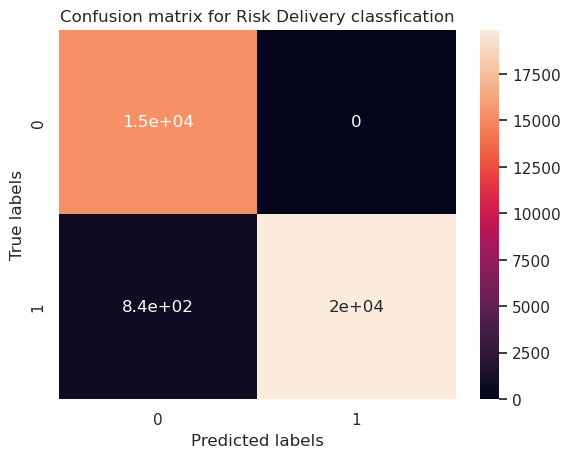

In [28]:
evaluation_risk_factor(l,m)

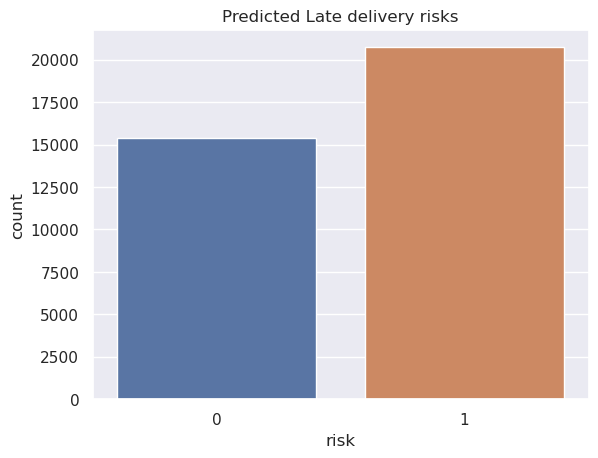

In [29]:
sns.set(style="darkgrid")
ax=sns.countplot(x="risk",data=prediction).set_title('Predicted Late delivery risks')

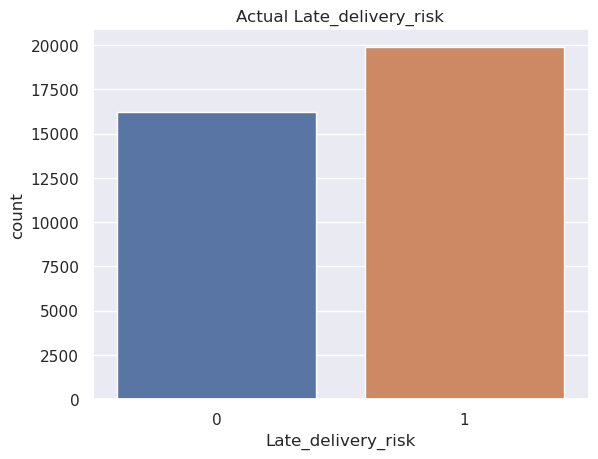

In [30]:
bx=sns.countplot(x='Late_delivery_risk',data=x_test).set_title('Actual Late_delivery_risk')

In [31]:
filename = 'deciscion_tree_estimator.pkl'
pickle.dump(model,open(filename,'wb'))

In [35]:
import pandas as pd
import numpy as np

df['churn_flag'] = np.where(df['delivery_status'] == 'late', 1, 0)

noise = np.random.randint(0, 10, size=len(df))
df['churn_flag'] = np.where(noise < 1, 1 - df['churn_flag'], df['churn_flag'])

print(df)

   order_id delivery_status  churn_flag
0         1         on time           1
1         2            late           1
2         3         on time           0
3         4            late           1
4         5         on time           0


In [36]:
len(df)

5